In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"


In [20]:
def trunc_length(ds, nb_hours):
#function that truncates the data to only consider the first nb_hours hours
    df = ds.loc[ds.min_from_intime <=  nb_hours]
    df = df.loc[df.min_from_intime > 0]
    return df

def create_batchs(ds):
    batchs = []
    ids = ds.stay_id.unique()
    for i in ids:
        batchs.append(ds.loc[ds['stay_id'] == i])
    return batchs

def remove_missing(df, var, threshold):
#remove from batch the entries where a too large proportion of the variables var are missing 
    res = df
    
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    for vital in var: 
        criterion = missing_value_df.loc[missing_value_df.column_name == vital].percent_missing >= threshold 
        if criterion:
            print('entry removed')
            print(missing_value_df.loc[missing_value_df.column_name == vital].percent_missing)
            df.drop([vital], axis = 1)
        else:
            res.append(batch[i])
    return res

def get_column_name(df):
    listn = [col for col in df.columns]
    return listn

def aggregation(batch, rate):
    'function that takes a batch of patients and returns the aggregated vitals with the correct aggregation rate'
    if rate == 1:
        return batch
    elif rate == 24:
        bch = []
        for df in batch:
            df['hour_slice'] = 0
            df['hour_slice'][range(25,49)] = 1
            df = df.groupby('hour_slice').mean()
            bch.append(df)
        return bch
    elif rate == 48:
        bch = []
        for df in batch:
            df['hour_slice'] = 0
            df = df.groupby('hour_slice').mean()
            bch.append(df)
        return bch



In [35]:
df = pd.read_csv('ICP_analysis.csv', delimiter=',').drop(columns = ['icu_intime','stay_id.1'])
print(df)
df = trunc_length(df, 2880)
df_org = df
df = df.pivot_table(index = ['stay_id', 'min_from_intime'], columns = ['feature_name', 'gcs'], values = ['feature_mean_value', 'gcs'])
df = df.reset_index(level=['stay_id'])
batch = create_batchs(df)
for i in range(len(batch)):
    batch[i] = batch[i].reindex(range(1, 48*60 + 1), fill_value = None) 

print(df)
print(len(batch))

       stay_id feature_name  feature_mean_value  min_from_intime gender  age  \
0     30614207          ICP                 9.0               13      M   74   
1     30614207          ICP                12.0               25      M   74   
2     30614207          ICP                 6.0               40      M   74   
3     30614207          ICP                 7.0              100      M   74   
4     30614207          ICP                10.0              160      M   74   
...        ...          ...                 ...              ...    ...  ...   
4442  39423338          ICP                20.0             2456      M   82   
4443  39423338          ICP                19.0             2516      M   82   
4444  39423338          ICP                20.0             2576      M   82   
4445  39423338          ICP                15.0             2636      M   82   
4446  39423338          ICP                19.0             2696      M   82   

           los     bmi  death  gcs  
0 

ValueError: Grouper for 'gcs' not 1-dimensional

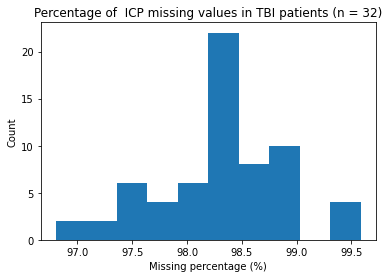

In [28]:
ICP_missing = []
import numpy as np
import matplotlib.pyplot as plt 

for i in range(len(batch)):
    percent_missing = batch[i].isnull().sum() * 100 / len(batch[i])
    ICP_missing.append(percent_missing.values)

plt.hist(np.concatenate(ICP_missing))
plt.title('Percentage of  ICP missing values in TBI patients (n = 32)')
plt.xlabel('Missing percentage (%)')
plt.ylabel('Count')
plt.savefig('ICP_missing_values.png')


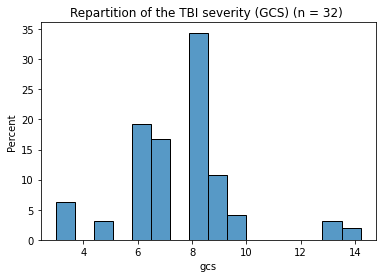

In [41]:
#GCS of patients having ICP
fig = sns.histplot(data = df_org, x = "gcs", multiple="stack", binwidth=0.7, stat = 'percent').set(title='Repartition of the TBI severity (GCS) (n = 32) ')
plt.savefig("icp_gcs.png") 